# Confirmed cases and country trajectory charts for Lithuania
> Day by day statistics of new confirmed cases and comparison with other countries.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/diagram2.png

In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
#hide
import os
cwd = os.getcwd()

import sys
sys.path.append(os.path.join(cwd, 'scripts'))

import seaborn as sns
from IPython.display import HTML
%matplotlib inline
sns.set()

from scripts.data import get_covid_data, get_growth_rate_data
from scripts.plots import plot_confirmed_cases_barplot, plot_new_cases_barplot, make_since_chart

In [3]:
#hide
df = get_covid_data()

## Number of total cases in Lithuania

Number of total cases grows exponentially.

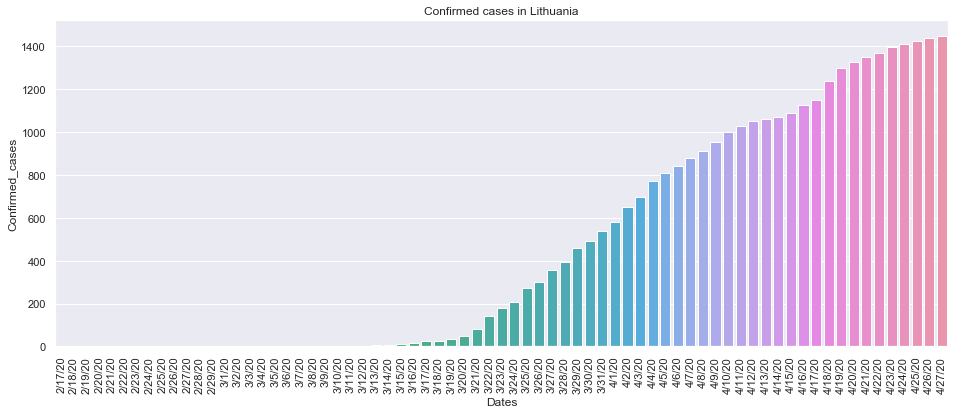

In [4]:
#hide_input
plot_confirmed_cases_barplot(df, 'Lithuania', cutoff=30)

Logarithmic scale shows how fast the number of new cases each day is increasing.

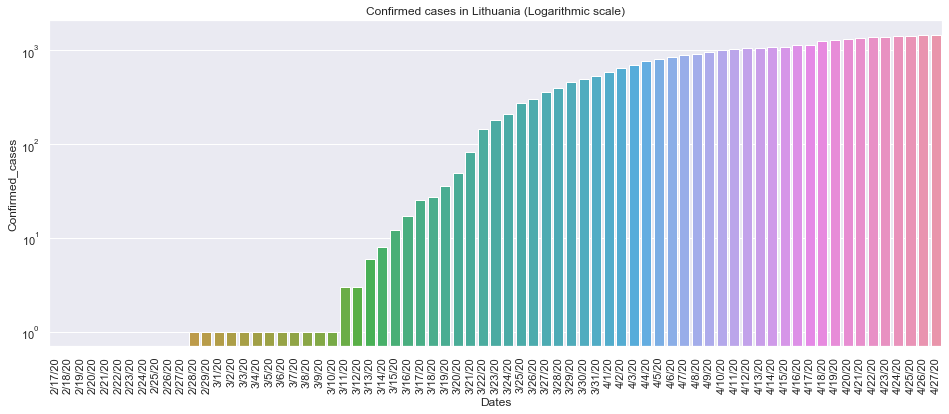

In [5]:
#hide_input
plot_confirmed_cases_barplot(df, 'Lithuania', cutoff=30, logarithmic_scale=True)

## Daily new cases

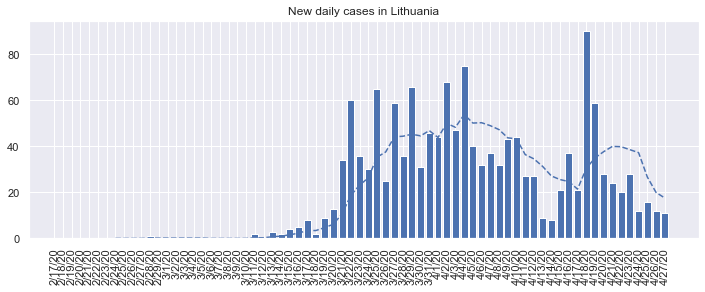

In [6]:
#hide_input
plot_new_cases_barplot(df, 'Lithuania')

## Country trajectories for total cases

Compare how the growth rate is different from other countries and their trajectories. By days since 100th confirmed case.

> Tip: Click (Shift+ for multiple) on countries in the legend to filter the visualization. 

In [7]:
#hide
countries_to_show = ['Lithuania', 'Poland', 'United States' , 'Belgium', 'United Kingdom', 'China', 'Italy', 'Germany', 'Estonia', 'US', 'France', 'Japan', 'South Korea', 'Latvia', 'Spain']
baseline_countries = ['Italy']
dff2 = get_growth_rate_data(df, countries_to_show)

In [8]:
#hide_input
chart3 = make_since_chart(dff2, ['South Korea', 'Japan', 'Lithuania', 'China'], baseline_countries)
chart3

alt.LayerChart(...)

In [9]:
#hide_input
chart3 = make_since_chart(dff2, ['Lithuania', 'Latvia', 'Estonia'], baseline_countries)
chart3


alt.LayerChart(...)

In [10]:
#hide_input
chart2 = make_since_chart(dff2, ['Spain', 'Germany', 'Belgium'], baseline_countries)
chart2

alt.LayerChart(...)

In [11]:
#hide_input
chart2 = make_since_chart(dff2, ['Poland', 'Lithuania'], baseline_countries)
chart2

alt.LayerChart(...)

In [12]:

#hide_input
chart2 = make_since_chart(dff2, ['US', 'United Kingdom', 'Spain', 'South Korea', 'Japan', 'China'], baseline_countries)
chart2

alt.LayerChart(...)

## New daily cases in other countries

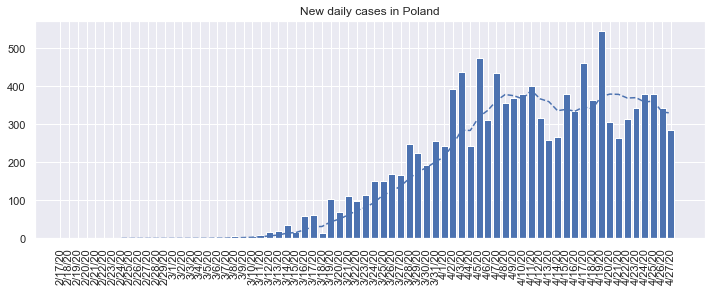

In [13]:
#hide_input
plot_new_cases_barplot(df, 'Poland')

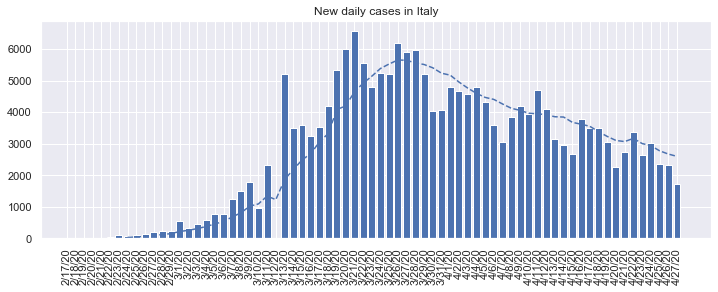

In [14]:
#hide_input
plot_new_cases_barplot(df,'Italy')

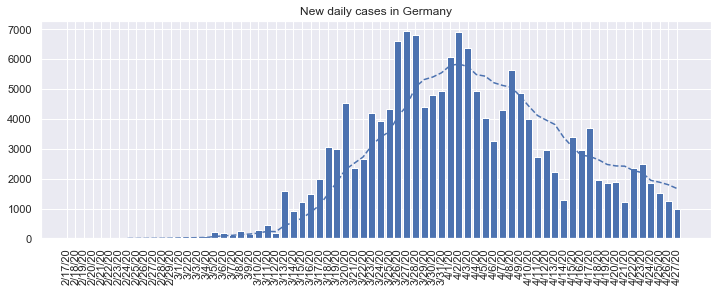

In [15]:
#hide_input
plot_new_cases_barplot(df, 'Germany')

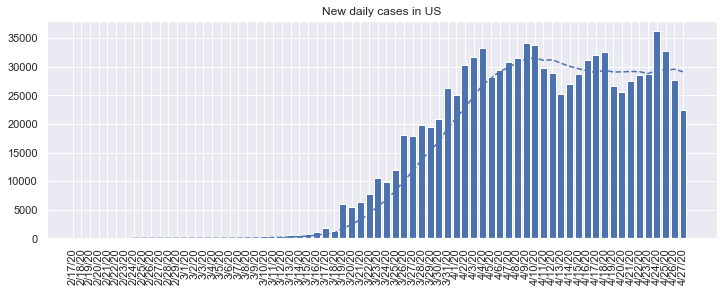

In [16]:
#hide_input
plot_new_cases_barplot(df, 'US')

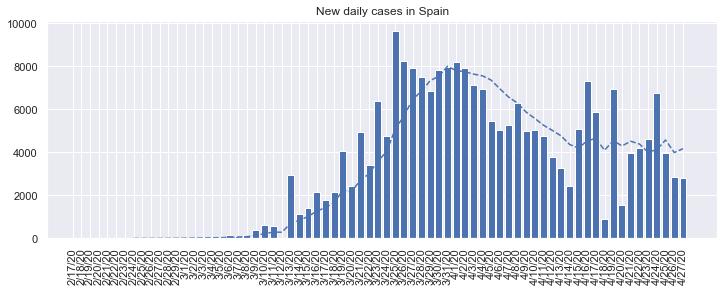

In [17]:
#hide_input
plot_new_cases_barplot(df, 'Spain')

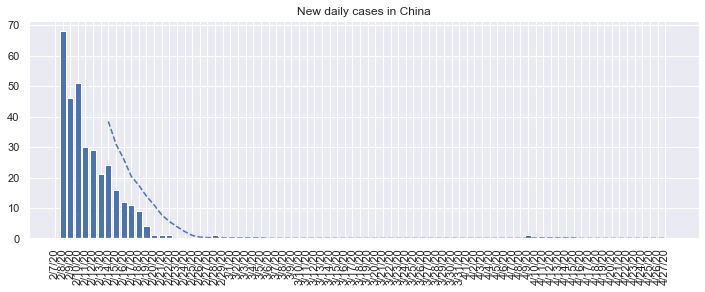

In [18]:
#hide
plot_new_cases_barplot(df, 'China', cutoff=20)

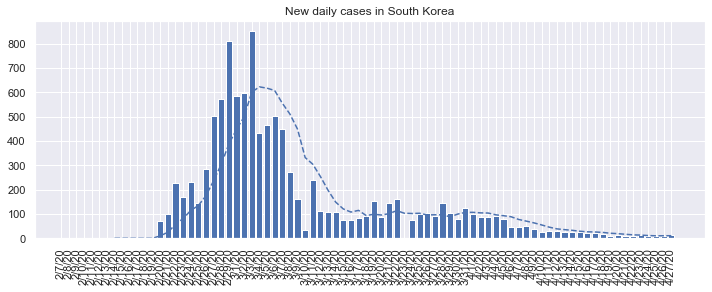

In [19]:
#hide_input
plot_new_cases_barplot(df, 'South Korea', cutoff=20)

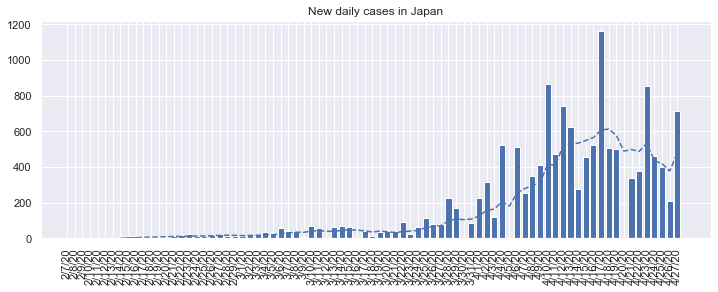

In [20]:
#hide_input
plot_new_cases_barplot(df, 'Japan', cutoff=20)

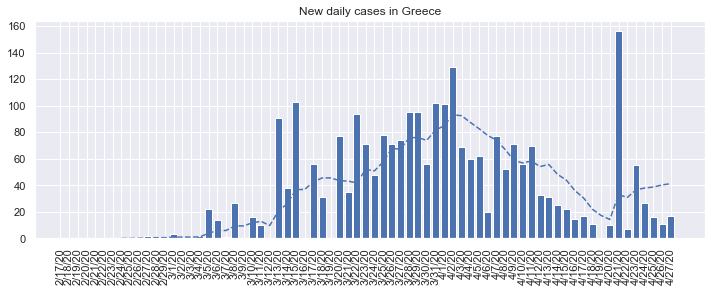

In [21]:
#hide_input
plot_new_cases_barplot(df,'Greece')

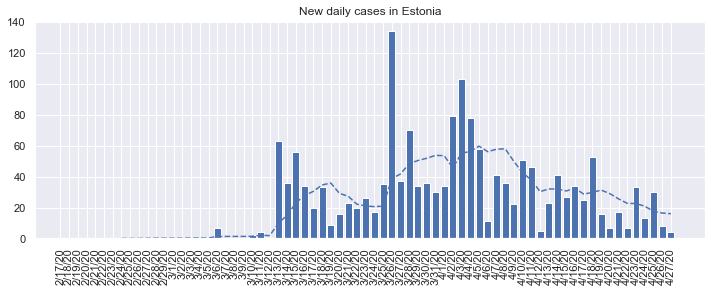

In [22]:
#hide_input
plot_new_cases_barplot(df, 'Estonia')

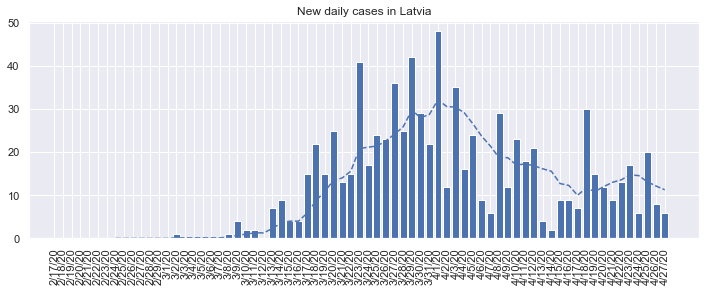

In [23]:
#hide_input
plot_new_cases_barplot(df, 'Latvia')

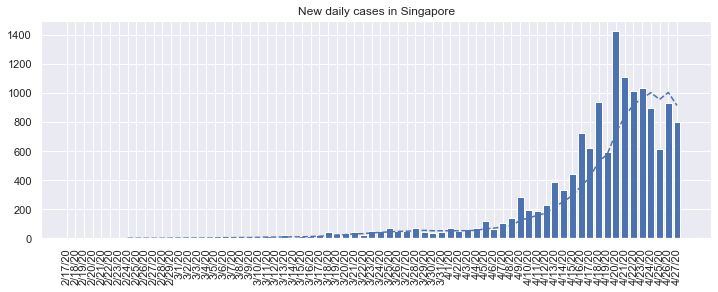

In [24]:
#hide_input
plot_new_cases_barplot(df, 'Singapore')